<a href="https://colab.research.google.com/github/nedokormysh/Stepik_Ai_edu_practical_ML/blob/week_8_KNN_LSH/KNN_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Метрические алгоритмы. Практика

В этом домашнем задании вы будете решать задачу классификации бутылок вина по различным характеристикам.

## Импорт библиотек, установка константных значений

In [111]:
import pandas as pd
import numpy as np

In [112]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.75

In [113]:
rng = np.random.default_rng(RANDOM_STATE)

## Загрузка данных

In [114]:
from sklearn.datasets import load_wine

data = load_wine(as_frame=True)

X = data.data
y = data.target

## Задание 1

Посмотрите на количество классов и количество объектов каждого класса в датасете.

**Вопрос**:  
Сколько классов в задаче?

In [115]:
y.nunique()

3

## Задание 2

Мы имеем дело с многоклассовой классификацией. Кроме того, классы не очень хорошо сбалансированы, поэтому для оценки качества модели метрика *accuracy* не подойдет.

Разбейте данные на тренировочную и тестовую части:  
тестовая часть - 25% от всех данных, зафиксируйте `random_state = RANDOM_STATE`.

In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, train_size=TRAIN_SIZE)

**Вопрос:**

Все ли признаки в данных одного масштаба?  
Проверьте это, выведя основные числовые характеристики матрицы `X_train` методом `describe` из библиотеки `pandas`.

По полученной таблице числовых характеристик определите, какой признак измеряется в сотнях?  
(если вариантов несколько, выберите признак с наибольшим средним значением).

In [117]:
X_train.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,12.972857,2.386842,2.362180,19.433835,100.759398,2.277068,2.021203,0.363534,1.608647,5.017594,0.959444,2.610000,742.992481
std,0.829993,1.098905,0.280606,3.467312,14.999571,0.645696,1.005537,0.126923,0.576964,2.202516,0.234545,0.729961,306.867593
min,11.030000,0.890000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.420000,1.740000,0.480000,1.270000,278.000000
25%,12.290000,1.640000,2.210000,17.200000,88.000000,1.700000,1.200000,0.260000,1.250000,3.250000,0.780000,1.830000,500.000000
50%,12.990000,1.900000,2.360000,19.400000,98.000000,2.230000,2.140000,0.340000,1.560000,4.800000,0.970000,2.810000,675.000000
75%,13.690000,3.170000,2.540000,21.500000,108.000000,2.800000,2.880000,0.450000,1.960000,6.130000,1.120000,3.200000,970.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,10.800000,1.710000,4.000000,1547.000000


In [118]:
X_desc = X.describe()
cols = X_desc.columns
sign_in_hundreds = []
for col in cols:
    v_min = X_desc.at['min', col]
    if v_min/100>=1.0:
        sign_in_hundreds.append(col)

#
print(sign_in_hundreds)

['proline']


## Задание 3

KNN требует того, чтобы все признаки были одного масштаба, поэтому масштабируйте данные при помощи `StandardScaler`.

Напоминаем, что обучать метод нужно только по тренировочным данным, а применять и к трейну, и к тесту.

После применения `StandardScaler` преобразуйте `X_train` и `X_test` к типу `pd.DataFrame`, названия новых объектов оставьте `X_train` и `X_test`.

In [119]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

Обучите KNN с параметрами по умолчанию на тренировочных данных и сделайте предсказание на тесте.

In [120]:
from sklearn.neighbors import KNeighborsClassifier

kn_model = KNeighborsClassifier()

In [121]:
kn_model.fit(X_train, y_train)

y_pred = kn_model.predict(X_test)

Будем измерять качество модели по метрике weighted $f1$-score.

Чтобы выбрать тип усреднения (micro, macro, weighted) в функции `f1_score` необходимо задать этот тип в гиперпараметре `average`.

Вычислите $f1$-score на тестовых данных.

**Вопрос:**

Чему равен $f1$-score на тестовых данных?

In [122]:
from sklearn.metrics import f1_score

round(f1_score(y_test, y_pred, average='weighted'), 2)

0.96

## Задание 4

Попробуем улучшить модель.

Подберите оптимальное количество соседей (`n_neighbors`) из диапазона *от 3 до 30 с шагом 2* и веса соседей (`weights`):  
`uniform`, `distance` по кросс-валидации с тремя фолдами на тренировочных данных.

Используйте `GridSearchCV` и метрику `f1_weighted`.

In [123]:
import numpy as np

In [124]:
np.arange(2, 31, 2)

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])

In [125]:
from sklearn.model_selection import GridSearchCV

grid = {'n_neighbors': np.arange(2, 31, 2),
         'weights' : ['uniform', 'distance']}

gs = GridSearchCV(kn_model, param_grid=grid, cv=3, scoring = 'f1_weighted')

gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]),
                         'weights': ['uniform', 'distance']},
             scoring='f1_weighted')

Возьмите best_estimator_, полученный при обучении GridSearchCV и с помощью него  
сделайте предсказание на тесте и вычислите метрику `f1_weighted`.

In [126]:
y_preds = gs.best_estimator_.predict(X_test)

round(f1_score(y_test, y_preds, average='weighted'), 2)

0.96

In [108]:
# estimator_KNN = KNeighborsClassifier(algorithm='auto')

# n_neighbors = list([x for x in range(3, 30, 2)])
# weights=['uniform', 'distance']

# parameters_KNN = {
#     'n_neighbors': n_neighbors,
#     'weights': weights
# }

# grid_search_KNN = GridSearchCV(
#     estimator=estimator_KNN,
#     param_grid=parameters_KNN,
#     scoring = 'f1_weighted',
#     cv = 3
# )

# gs = grid_search_KNN.fit(X_train, y_train)

# print('gs.best_score_: ', gs.best_score_) # качество наилучшей модели (с оптимальными гиперпараметрами)
# print('gs.best_params_: ', gs.best_params_) # оптимальные гиперпараметры
# print('gs.best_estimator_: ', gs.best_estimator_) #

# neigh = gs.best_estimator_
# neigh.fit(X_train, y_train)
# y_pred = neigh.predict(X_test)
# f1_score_val = f1_score(y_test, y_pred, average='weighted')
# print(round(f1_score_val, 2))

gs.best_score_:  0.9623290498688744
gs.best_params_:  {'n_neighbors': 19, 'weights': 'distance'}
gs.best_estimator_:  KNeighborsClassifier(n_neighbors=19, weights='distance')
0.96


**Вопрос:**

Удалось ли при помощи подбора гиперпараметров улучшить качество модели на тестовых данных?

## Задание 5

Выведите на экран матрицу ошибок.

Используйте модель с подобранными при помощи `GridSearch` гиперпараметрами.


**Вопрос:**  
По этой матрице определите, какие классы между собой путает модель?

In [127]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_preds)

array([[15,  0,  0],
       [ 1, 16,  1],
       [ 0,  0, 12]])

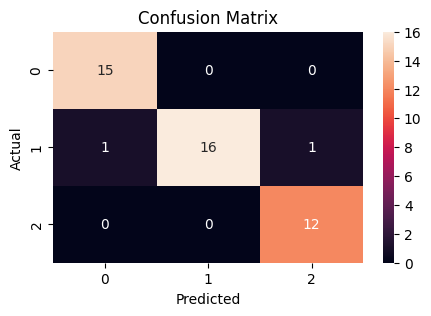

In [130]:
# Import the required libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Data
a = confusion_matrix(y_test, y_preds)

# Select Confusion Matrix Size
plt.figure(figsize = (5,3))

# Create Confusion Matrix
b = sns.heatmap(a, annot=True)

# Set the Title
b.set(title='Confusion Matrix')

# Set the Labels
b.set(xlabel='Predicted', ylabel='Actual')

# Display the Confusion Matrix
plt.show()

## Бонус (эксперименты с LSH)

Скопируйте все функции из [ноутбука в уроке "Быстрый поиск соседей"](https://colab.research.google.com/drive/181MMOcTnzdMVzJr0pWzqtEG0-BV9BIHH).

In [131]:
def knn_search(query, data, k=5):

    dists = np.sqrt(np.sum((data - query) ** 2, axis=1))  # вычисляем расстояния от объекта query до всех точек датасета
    inds = np.argsort(dists)  # сортируем по возрастанию расстояний
    inds_k = inds[:k]         # берем top-k точек с наименьшими расстояниями

    return data[inds_k], dists[inds_k]

При помощи `knn_search` найдите ближайших соседей к вину `X_test.iloc[0]` в **тренировочных** данных.

Обратите внимание, что функция `knn_search` принимает на вход `np.array`, а не `pd.DataFrame`. Поэтому переведите аргументы в `np.array`, приписав к необходимому объекту $X$: `X.values`.

In [132]:
q = X_test.iloc[0].values

In [134]:
%%time

neighbors, dists = knn_search(q, X_train.values)
for i, (neighbor, dist) in enumerate(zip(neighbors, dists)):
    print(f"top {i + 1}: dist = {dist}")

top 1: dist = 1.7873320988662762
top 2: dist = 1.9809624052592747
top 3: dist = 2.1601016426727613
top 4: dist = 2.270974564253457
top 5: dist = 2.3117955237515453
CPU times: user 3.63 ms, sys: 0 ns, total: 3.63 ms
Wall time: 10.1 ms


Выведите на экран признаки объекта `X_test.iloc[0]` и признаки ближайшего найденного соседа.

In [136]:
X_test.iloc[0].values

array([ 0.80683207,  0.65142516,  0.70763713, -1.22568751,  1.01991065,
        0.65747817,  1.00703506, -1.53058075,  0.08934271,  0.03755595,
        0.00238119,  1.03133729,  0.33367219])

In [138]:
neighbors[0]

array([ 1.50827494,  1.46438454,  0.52877788, -1.80468392,  1.82295821,
        1.12384935,  1.01701759, -1.2933229 ,  0.82004316,  0.03755595,
       -0.29719787,  1.26510707,  0.05563253])

In [140]:
round(dists[0], 2)

1.79

**Вопрос:**

Можно ли сказать, что в тренировочных данных есть вино, почти такое же как `X_test.iloc[0]`? (все признаки почти одинаковые)

Какое расстояние между объектом запроса и первым ближайшим соседом?

Теперь найдите ближайшего соседа при помощи `approx_knn_search`.

In [141]:
def generate_hyperplanes(data, bucket_size=16):
    m = data.shape[0]            # число объектов
    n = data.shape[1]            # число признаков
    b = m // bucket_size         # количество корзин
    h = int(np.log2(b))          # количество гиперплоскостей
    H = rng.normal(size=(h, n))  # гиперплоскости, заданные своими нормалями
    return H

In [142]:
def hamming_hash(data, hyperplanes):
    b = len(hyperplanes)
    hash_key = (data @ hyperplanes.T) >= 0

    dec_vals = np.array([2 ** i for i in range(b)], dtype=int)
    hash_key = hash_key @ dec_vals

    return hash_key

In [143]:
def locality_sensitive_hash(data, hyperplanes):
    hash_vals = hamming_hash(data, hyperplanes)
    hash_table = {}
    for i, v in enumerate(hash_vals):
        if v not in hash_table:
            hash_table[v] = set()
        hash_table[v].add(i)

    return hash_table

In [144]:
def approx_knn_search(query, data, k=5, bucket_size=16):
    candidates = set()

    hyperplanes = generate_hyperplanes(data)
    hash_table = locality_sensitive_hash(data, hyperplanes) # формируем хеш-таблицу по датасету

    query_hash = hamming_hash(query, hyperplanes)
    if query_hash in hash_table:
        candidates = candidates.union(hash_table[query_hash])
    candidates = np.stack([data[i] for i in candidates], axis=0) # находим кандидатов = объекты, попадающие с query в одну корзину

    return knn_search(query, candidates, k=k) # с помощью KNN ищем ближайших соседей только из найденных кандидатов

In [145]:
%%time

neighbors, dists = approx_knn_search(q, X_train.values)

for i, (neighbor, dist) in enumerate(zip(neighbors, dists)):
    print(f"top {i + 1}: dist = {dist}")

top 1: dist = 1.787332098866276
top 2: dist = 2.3117955237515453
top 3: dist = 2.4714256477971346
top 4: dist = 2.482865265933602
top 5: dist = 2.554033097597557
CPU times: user 5.65 ms, sys: 0 ns, total: 5.65 ms
Wall time: 15.8 ms


Ближайший сосед при помощи KNN+LSH может быть найден не точно или не с первого запуска.  
Запустите последнюю ячейку несколько раз и убедитесь, что ближайший сосед находится верно за несколько запусков.

**Вопрос:**

Запустите `knn_search` и `appox_knn_search` несколько раз и сравните время запусков. Какой из подходов в этой задаче работает быстрее?